# Twitter Sentiment Analizi ve ML Classification Projesi

# Genel Sentiment Analizi

##### snscrape kütüphanesini indirme

In [200]:
#!pip install snscrape

In [201]:
import warnings
warnings.filterwarnings("ignore")

In [202]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import itertools

## twitter dan yazdığımız veri hakkında veri elde etme

In [203]:
df = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper("çocukluk since:2020-11-13").get_items(),5000))

In [204]:
df.shape

(5000, 29)

In [205]:
df.columns

Index(['url', 'date', 'rawContent', 'renderedContent', 'id', 'user',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel', 'links',
       'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
       'inReplyToUser', 'mentionedUsers', 'coordinates', 'place', 'hashtags',
       'cashtags', 'card', 'viewCount', 'vibe'],
      dtype='object')

In [206]:
df.rawContent[10]

'@absurtolaylar Çocukluk travmam var, akşam sakız çiğnemek ölü şeyi çiğnemek gibidir derdi büyükler\nO zaman şunu sormayı akıl edemedim, peygamber zamanında sakız varmiydi?\nGeçiniz efendim bu safsatalari'

## Veriden elde ettiğimiz metinleri NLP ile düzenleme

In [207]:
df = df[["rawContent"]]

In [208]:
df.columns = ["text"]

In [209]:
df.head()

,text
0,bu da benim cocukluk travmasi https://t.co/gny...
1,@gracecilikkk benim bir tane çocukluk fotoğraf...
2,cocukluk travmam gulyabani aq
3,@zdgnr Balataları sıyırmama neden olan o çoçuk...
4,Asıl cocukluk tramvası


In [210]:
df['text']=df['text'].str.lower()
df['text']=df['text'].str.replace('[^\w\s]','')
df['text']=df['text'].str.replace('\n','')
df['text']=df['text'].str.replace('\d+','')
df['text']=df['text'].str.replace('\r','')

In [211]:
df.head()

,text
0,bu da benim cocukluk travmasi httpstcognyudntg
1,gracecilikkk benim bir tane çocukluk fotoğrafı...
2,cocukluk travmam gulyabani aq
3,zdgnr balataları sıyırmama neden olan o çoçukl...
4,asıl cocukluk tramvası


## Sentiment Analizi

#### Türkçe kelimelerin sentiment analizi için gerekli kütüphanelerin indirilmesi

In [212]:
#!pip install transformers

In [213]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

In [214]:
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sa= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

#### Sentiment Analizi

In [215]:
from textblob import TextBlob
def detect_sentiment(text):
  aziz = sa(text)
  if aziz[0]['label']== "positive":
    azizo = aziz[0]["score"]
    return azizo
  else:
    azizo = -aziz[0]["score"]
    return azizo

In [216]:
df["sentiment"] = df["text"].apply(detect_sentiment)

In [217]:
df.head()

,text,sentiment
0,bu da benim cocukluk travmasi httpstcognyudntg,-0.960093
1,gracecilikkk benim bir tane çocukluk fotoğrafı...,0.915266
2,cocukluk travmam gulyabani aq,-0.863709
3,zdgnr balataları sıyırmama neden olan o çoçukl...,0.944491
4,asıl cocukluk tramvası,-0.693236


In [218]:
import seaborn as sns

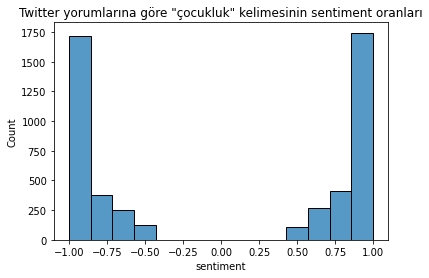

In [219]:
sns.histplot(df.sentiment).set(title='Twitter yorumlarına göre "çocukluk" kelimesinin sentiment oranları');

##### Pozitif, Negatif ve Nötr yorumları  belirleme

In [220]:
def sntmnt(score):
    if score>0.6:
        return "pozitif"
    elif score< (-0.6):
        return "negatif"
    else:
        return "nötr"

In [221]:
df["class"] = df["sentiment"].apply(sntmnt)

In [222]:
df.head(10)

,text,sentiment,class
0,bu da benim cocukluk travmasi httpstcognyudntg,-0.960093,negatif
1,gracecilikkk benim bir tane çocukluk fotoğrafı...,0.915266,pozitif
2,cocukluk travmam gulyabani aq,-0.863709,negatif
3,zdgnr balataları sıyırmama neden olan o çoçukl...,0.944491,pozitif
4,asıl cocukluk tramvası,-0.693236,negatif
5,onderseren o kadar çok özlüyorum ki son hava b...,-0.797500,negatif
6,yapay zekaya yaramasın diye çocukluk fotoğrafı...,-0.792711,negatif
7,ilkokula giden canım kardeşim ödevlerini hüngü...,0.556081,nötr
8,benim çocukluk travmaları httpstcolpgudoqfn,-0.871240,negatif
9,batuelsalvaje bu benim başka bi çocukluk travm...,-0.977051,negatif


In [223]:
df["class"].value_counts()

pozitif    2382
negatif    2285
nötr        333
Name: class, dtype: int64

# Machine Learning - Classification

#### Gerekli Kütüphaneleri İndirme ve Model Hazırlığı

In [224]:
from sklearn.feature_extraction.text import CountVectorizer

In [225]:
from nltk.stem import PorterStemmer 
pr=PorterStemmer()

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [226]:
def lemmafn(text):
    words=TextBlob(text).words
    return [pr.stem(word) for word in words]

In [227]:
vect=CountVectorizer(stop_words='english',ngram_range=(1,2),max_features=10000,analyzer=lemmafn)

In [228]:
x=df["text"]
y=df["class"]

In [229]:
y.value_counts()

pozitif    2382
negatif    2285
nötr        333
Name: class, dtype: int64

In [230]:
x=vect.fit_transform(x)

#### Logistic Regression ve Desicion Tree Modelleri ile Eğitme

x ile y yi öğrenme ve test için ayırma

In [231]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.20)

##### Model Kütüphanelerini import etme

In [232]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##### Logistic Regression ile Classification

In [233]:
l=LogisticRegression()

In [234]:
l.fit(x_train,y_train)

LogisticRegression()

In [235]:
pred1=l.predict(x_test)

In [236]:
accuracy_score(pred1,y_test)

0.642

##### Desicion Tree Classification

In [237]:
d=DecisionTreeClassifier()

In [238]:
d.fit(x_train,y_train)

DecisionTreeClassifier()

In [239]:
pred2 = d.predict(x_test)

In [240]:
accuracy_score(pred2,y_test)

0.609

#### Diğer Classification Modelleri ile Eğitme

##### Modellerin Kütüphanelerini import etme 

In [241]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

##### Modeller için Foksiyon Tanımlama ve Accuracy Oranını belirleme

In [242]:
def classification_test(x,y):
    
    b = BernoulliNB()
    k = KNeighborsClassifier()
    l = LogisticRegression()
    d = DecisionTreeClassifier()
    r = RandomForestClassifier()
    gb = GradientBoostingClassifier()
    
    
    x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.20, random_state=42)
    
    aziz_models = [b, k, l, d, r, gb]
    aziz_names = ["Bernoulli Naive Bayes", "K-Nearest Neighbors(KNN)", "Logistic Regression",
                 "Decision Tree", "Random Forest", "Gradient Boost"]
    
    accuracy = []    
    
    result = pd.DataFrame(columns = ["Accuracy"], index = aziz_names)
    
    for aziz in aziz_models:
        aziz.fit(x_train, y_train)
        az = aziz.predict(x_test)
        
        accuracy.append(accuracy_score(az, y_test))    
    
    result.Accuracy = accuracy
    
    return result.sort_values("Accuracy", ascending = False)

In [243]:
classification_test(x,y)

,Accuracy
Bernoulli Naive Bayes,0.662
Random Forest,0.645
Logistic Regression,0.642
Gradient Boost,0.610
Decision Tree,0.602
K-Nearest Neighbors(KNN),0.572


In [245]:
#df.to_csv("çocukluk_twitter.csv", index = False)

# Word Cloud

In [247]:
from wordcloud import WordCloud # wordcloud diye küçük yazınca kabul etmişti ?
from wordcloud import STOPWORDS
from PIL import Image # sitede bulunan tüm görselleri indirebiliyor
import numpy as np
import matplotlib.pyplot as plt

In [248]:
def wc(data,bgcolor):
    plt.figure(figsize=(30,30))
    mask = np.array(Image.open("cloud.png"))
    wc = WordCloud(background_color = bgcolor, stopwords=STOPWORDS, width=2400, height=1200, mask=mask) 
    wc.generate("".join(data))
    plt.imshow(wc)
    plt.axis("off")

In [249]:
df.head(10)

,text,sentiment,class
0,bu da benim cocukluk travmasi httpstcognyudntg,-0.960093,negatif
1,gracecilikkk benim bir tane çocukluk fotoğrafı...,0.915266,pozitif
2,cocukluk travmam gulyabani aq,-0.863709,negatif
3,zdgnr balataları sıyırmama neden olan o çoçukl...,0.944491,pozitif
4,asıl cocukluk tramvası,-0.693236,negatif
5,onderseren o kadar çok özlüyorum ki son hava b...,-0.797500,negatif
6,yapay zekaya yaramasın diye çocukluk fotoğrafı...,-0.792711,negatif
7,ilkokula giden canım kardeşim ödevlerini hüngü...,0.556081,nötr
8,benim çocukluk travmaları httpstcolpgudoqfn,-0.871240,negatif
9,batuelsalvaje bu benim başka bi çocukluk travm...,-0.977051,negatif


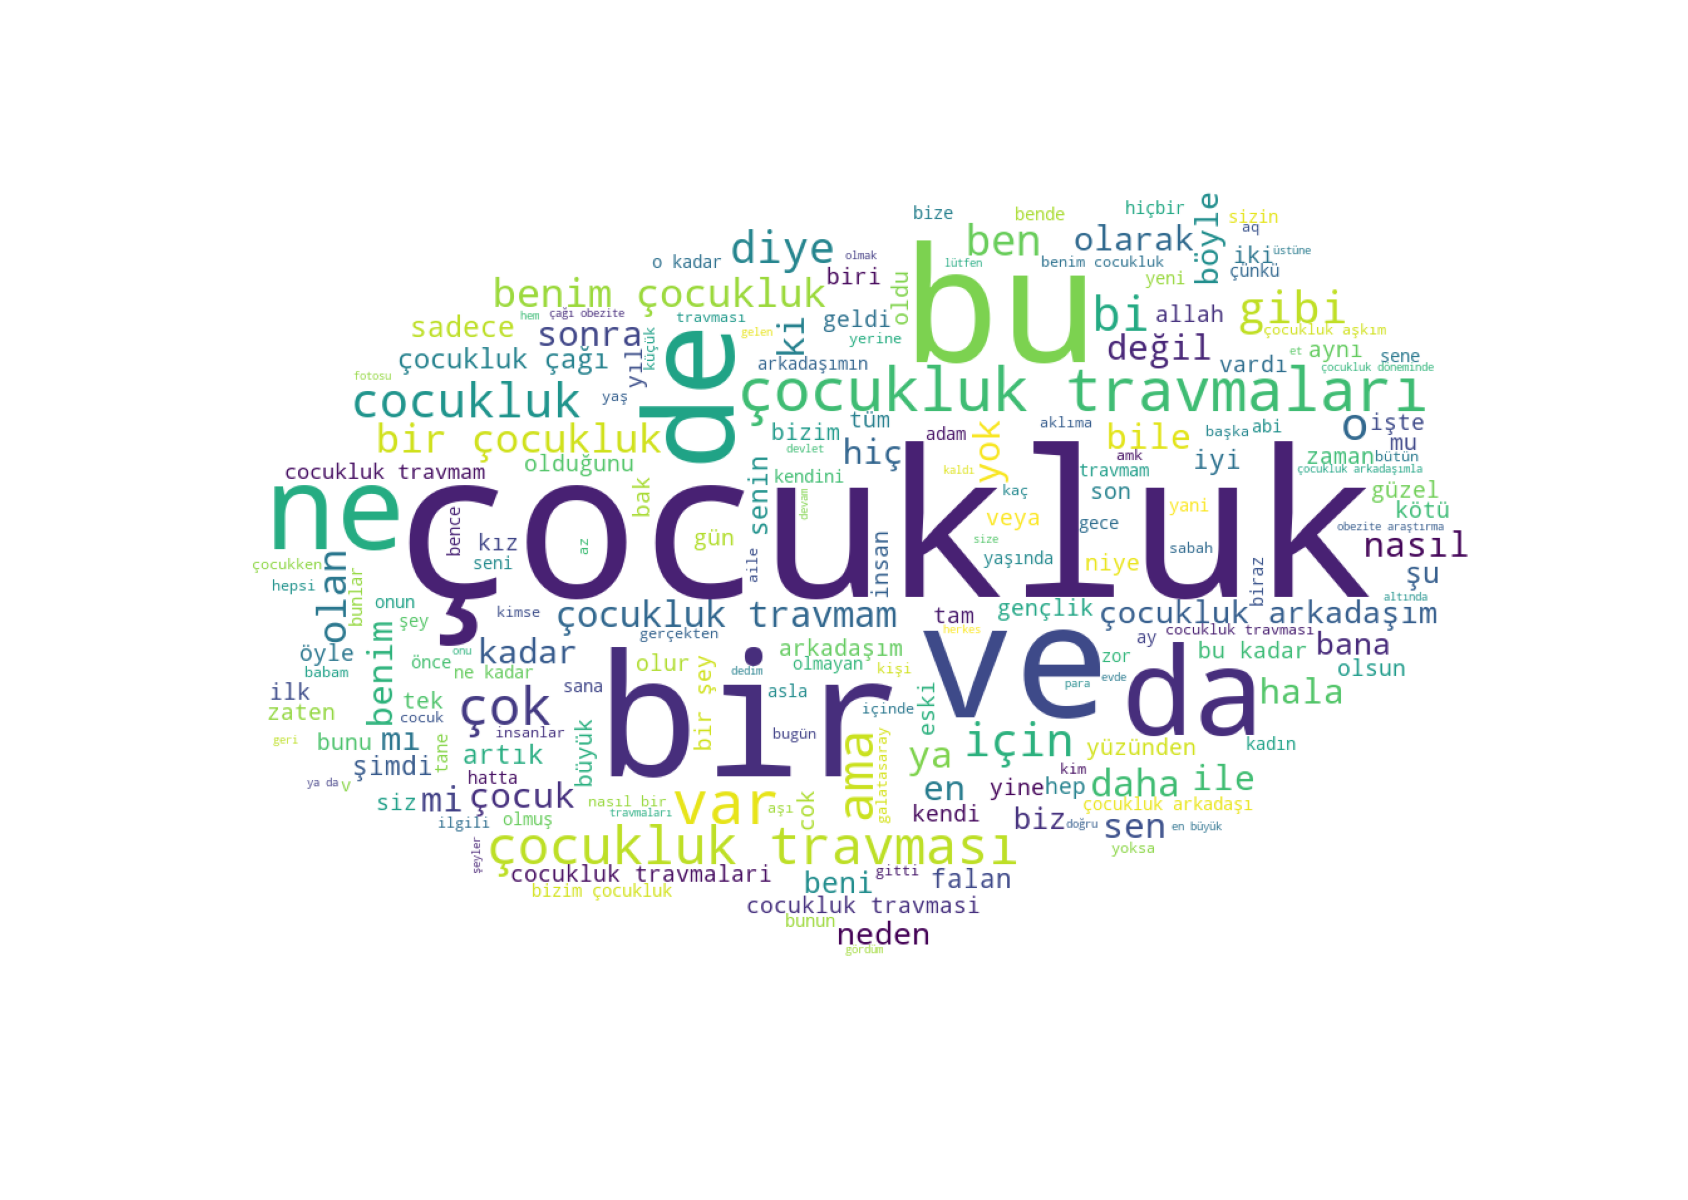

In [250]:
wc(df[df['class']=="negatif"]["text"], "white")

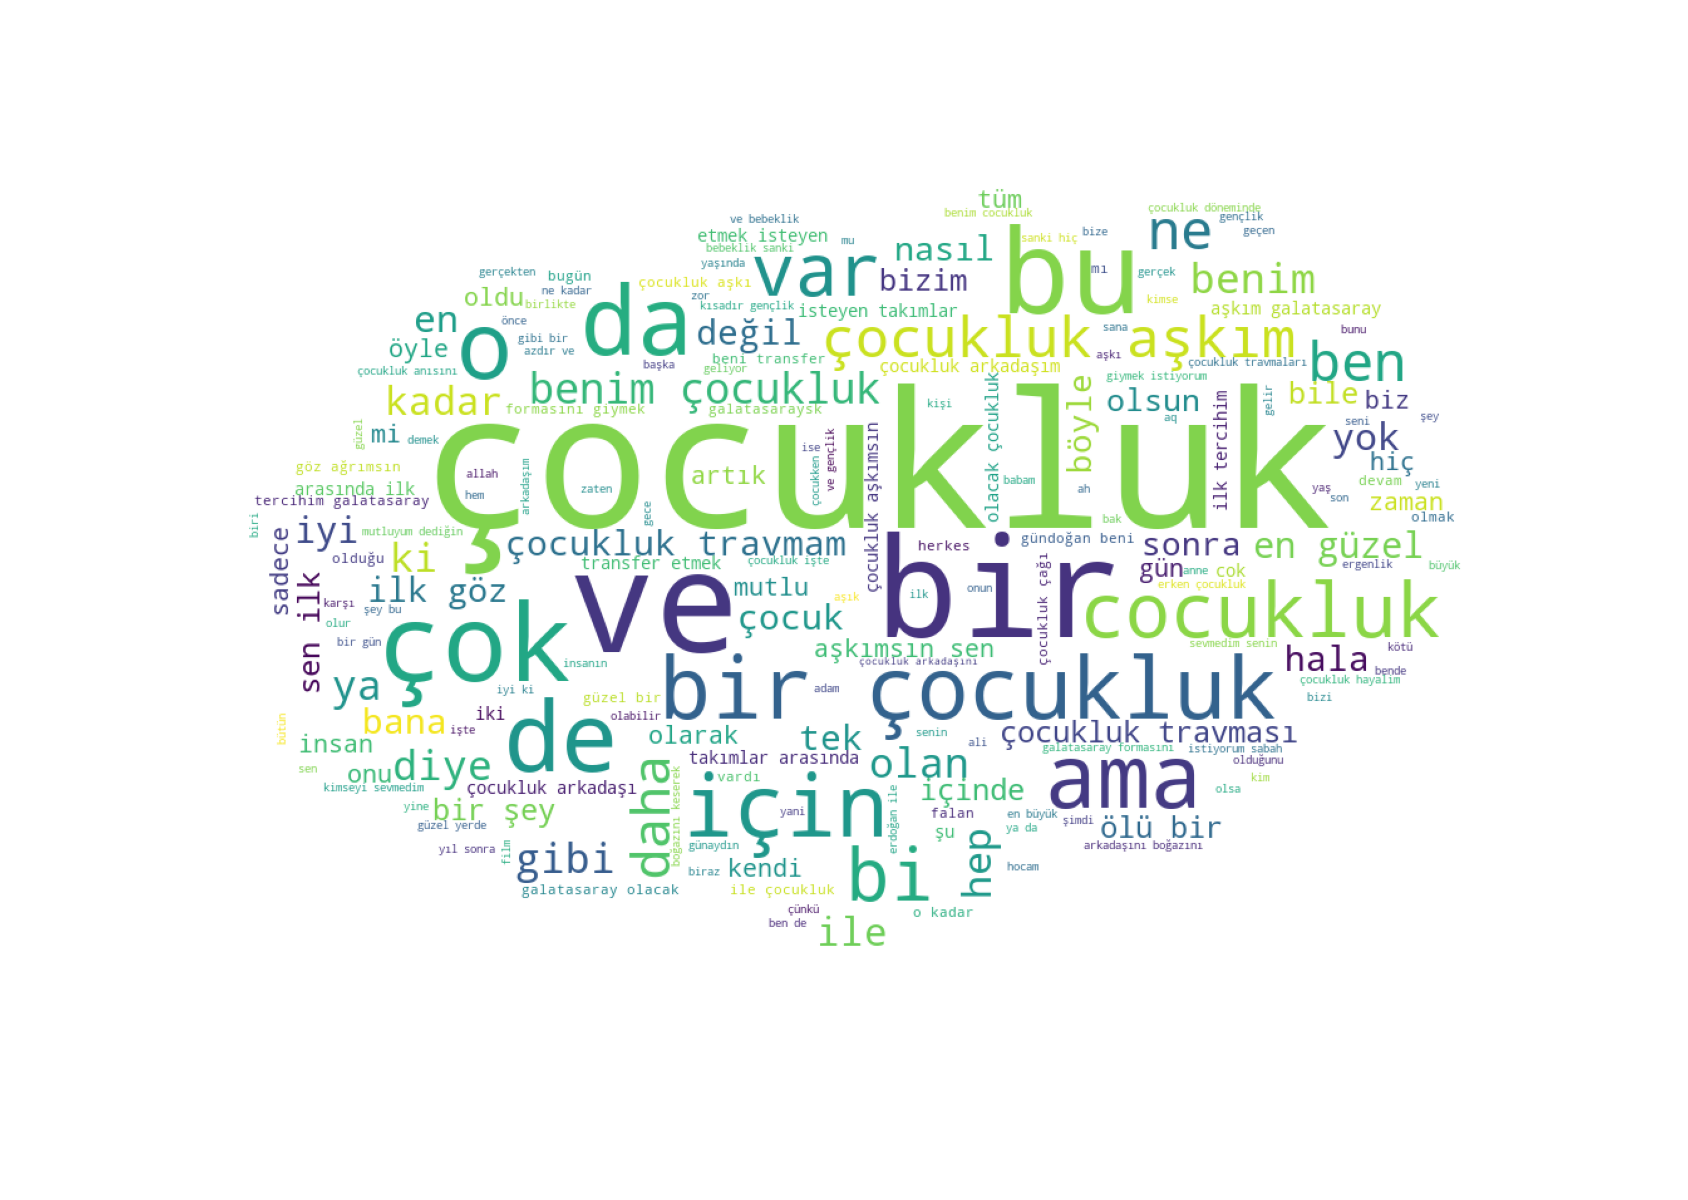

In [251]:
wc(df[df['class']=="pozitif"]["text"], "white")

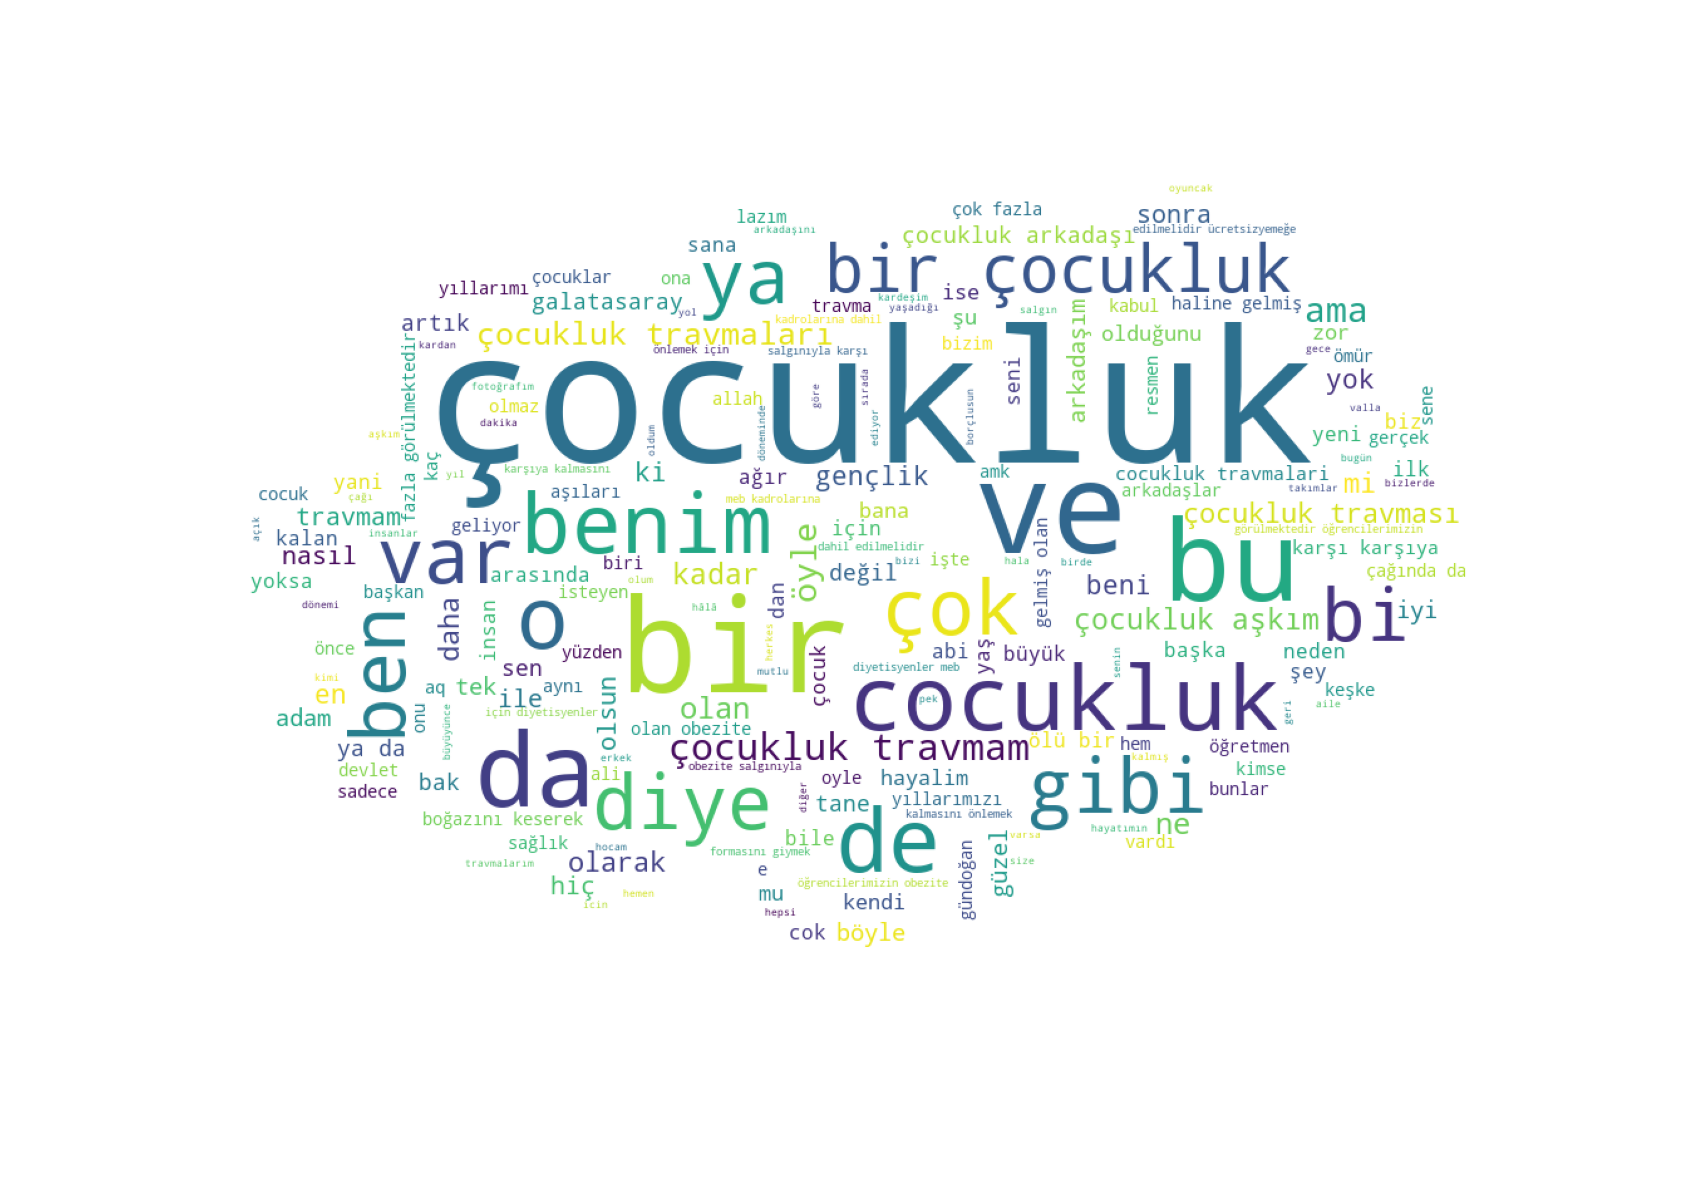

In [252]:
wc(df[df['class']=="nötr"]["text"], "white")